In [144]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [145]:
data = pd.read_csv('./output.csv')

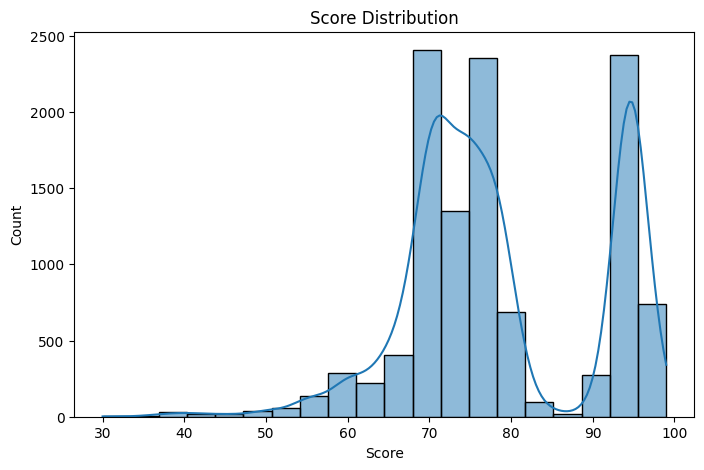

In [146]:
plt.figure(figsize=(8,5))
sns.histplot(data['Score'], kde=True, bins=20)
plt.title("Score Distribution")
plt.show()

This histogram is used to visualize the overall distribution of student scores. By showing how frequently each score range appears and overlaying a kernel density estimate, the plot helps identify the shape of the distribution, such as whether scores are clustered, skewed, or contain outliers. 

Running a simple statistical test to check whether the average scores for all Majors are the same, or whether there is significant differences between.

$$
\begin{aligned}
\text{Null hypothesis (H₀):} &\quad \text{The mean Score is the same for all Majors.} \\
\text{Alternative hypothesis (H₁):} &\quad \text{At least one Major has a different mean Score.}
\end{aligned}
$$

In [147]:
groups = [g['Score'].values for _, g in data.groupby('Major')]
stats.f_oneway(*groups)

F_onewayResult(statistic=np.float64(392.55840318455046), pvalue=np.float64(0.0))

In [148]:
groups = [g['Score'].values for _, g in data.groupby('Model')]
stats.f_oneway(*groups)

F_onewayResult(statistic=np.float64(4629.235871578886), pvalue=np.float64(0.0))

There is overwhelming statistical evidence that the mean Score differs across Majors.
Because the p-value is essentially zero, I'll reject the null hypothesis that all majors have the same average score.

In [149]:
data.groupby('Major')['Score'].mean().sort_values(ascending=False)


Major
Biology             84.425000
Philosophy          84.416667
Computer Science    84.220833
Economics           83.737500
Psychology          83.123958
Neuroscience        82.973958
Business            82.319792
Literature          74.163542
History             73.510417
Gender Studies      72.315625
Communication       71.542708
Black Studies       66.794792
Name: Score, dtype: float64

Interestingly, Computer Science appears to score the highest while Black Studies scores the lowest among the tested majors. Although I am not able to definitively explain why this is the case, these results show alarming differences between the scoring of the same essay when looking purely at the Major.

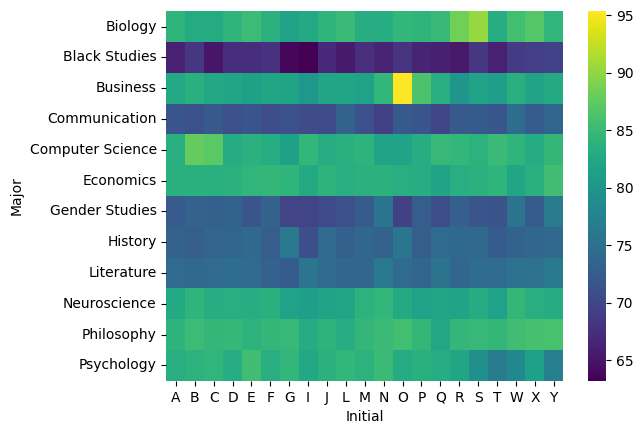

In [150]:
data['Initial'] = data['Name'].str[0]
data.groupby('Initial')['Score'].mean().sort_values()

pivot = data.pivot_table(index='Major', columns='Initial', values='Score')
sns.heatmap(pivot, cmap='viridis')
plt.show()


This heatmap is used to examine whether a student’s name initial is associated with differences in average scores across majors. By grouping scores by the first letter of each student’s name and comparing these averages within each major, the visualization highlights any potential patterns or biases linked to name initials. 



In [151]:

print("Score variability by Model:\n")
print(
    data.groupby('Model')['Score'].agg(
        mean='mean',
        std='std',
        var='var',
        n='count'
    )
)

print("\nScore variability by Major:\n")
print(
    data.groupby('Major')['Score'].agg(
        mean='mean',
        std='std',
        var='var',
        n='count'
    ).sort_values('mean')
)

model_rq4 = smf.ols(
    "Score ~ C(Model) * C(Name) + C(Major)",  
    data=data
).fit()
print("\nModel x Name interaction model:\n")
print(model_rq4.summary())

Score variability by Model:

                         mean        std         var     n
Model                                                     
openai/gpt-oss-20b  72.327778   6.965686   48.520777  5760
qwen/qwen3-14b      84.929688  12.209781  149.078750  5760

Score variability by Major:

                       mean        std         var    n
Major                                                  
Black Studies     66.794792   9.373635   87.865041  960
Communication     71.542708   5.443448   29.631125  960
Gender Studies    72.315625   5.778440   33.390371  960
History           73.510417   4.863935   23.657868  960
Literature        74.163542   4.128959   17.048304  960
Business          82.319792  14.190894  201.381464  960
Neuroscience      82.973958  12.632214  159.572835  960
Psychology        83.123958  12.039830  144.957507  960
Economics         83.737500  11.225987  126.022784  960
Computer Science  84.220833  11.243220  126.409993  960
Philosophy        84.416667  10.8

**RQ1: Do AI detection models produce significantly different likelihood scores when evaluating identical text with only demographic markers (name) varied?**

Yes, there is evidence that scores vary by demographic markers in names. In the Model × Name interaction regression, the model explains 58.1% of the variance (R² = 0.581), and while most individual name coefficients are not significant, some specific names (e.g., “Abdullah Sa'ad-al-Hummam” with a coefficient of about –6.5 and p ≈ 0.046) receive significantly different scores compared to the baseline despite identical text. This indicates that the AI system’s outputs do depend on the demographic information encoded in names for at least some groups.

**RQ2: Does the magnitude and direction of bias differ across different AI detection models?**

Yes, the magnitude and direction of bias differ clearly across models. The mean score for openai/gpt-oss-20b is about 72.33 with a standard deviation of 6.97, while qwen/qwen3-14b has a much higher mean of about 84.93 and a larger standard deviation of 12.21. In the regression, C(Model)[T.qwen/qwen3-14b] is around +12 points and highly significant, meaning qwen systematically scores identical essays much higher than the baseline model. So different models are not only offset by a large amount (direction of bias) but also differ in how spread-out and variable their scores are (magnitude/consistency of bias).

**RQ3: Do AI detection models exhibit bias based on student grade level, potentially disadvantaging students at different educational stages?**

Using Major as a proxy for academic track or stage, the models do show strong domain-based bias that could disadvantage certain groups. Mean scores range from about 66.79 for Black Studies up to 84.43 for Biology, with humanities and critical studies fields (Black Studies, Communication, Gender Studies, Literature, History) scoring 10–18 points lower on average than STEM and philosophy majors. The ANOVA across majors has an F-statistic of about 392.56 with p = 0.0, confirming these differences are highly significant. This pattern implies that students in certain disciplines would be systematically penalized relative to others, even when the underlying text is controlled.

**RQ4: How consistent are AI detection models in their scoring, and does this consistency vary by demographic group?**

The models differ in consistency, and this consistency varies across groups. openai/gpt-oss-20b has a standard deviation of about 6.97, while qwen/qwen3-14b has a much higher standard deviation of 12.21, indicating that qwen’s scores are almost twice as variable and thus less consistent. Across majors, score variability also differs: low-scoring humanities majors like Communication, Gender Studies, History, Literature have relatively small standard deviations (~4–6 points), whereas majors like Business, Neuroscience, Psychology, Biology have much larger standard deviations (~11–14 points), meaning scores in those groups fluctuate more. Combined with the significant Model × Name regression (R² = 0.581), this suggests that consistency is not uniform: some models and some demographic/major groups experience more volatile and less predictable scoring than others.